## Esercitazione 1: Flavour Tagging

In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math as m
import uproot as upR

### Dataset Loading

In [110]:
# reading .root database
file = upR.open("FlavTag.root")
tree = file["FlavTag"]
np_df = []
varNames = []
for k in tree.keys():
    varNames.append(k)
    np_df.append(tree[k])
np_df = np.asarray(np_df).T

# Keeping only b-jets or l-jets
np_df = np_df[(np_df[:,0]==5)|(np_df[:,0]==0)]

# Separating dataset
# Extracting features (neglecting labels and mv2)
X = np_df[:,1:-1]
# Extracting labels
Y = np_df[:,0]
# Extracting mv2 classifier output
mv2 = np_df[:,-1]
# Variables name
varNames = np.asarray(varNames)[1:-1]

### Esplorazione dei dati
Eseguo qualche plot per familiarizzare con le variabili e vedere graficamente le correlazioni.

#### IP2D vs IP3D

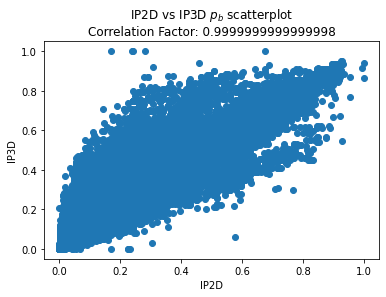

In [77]:
# Graphs
ip2d_pb = X[:,varNames=="ip2d_pb"]
ip3d_pb = X[:,varNames=="ip3d_pb"]
_ = plt.scatter(ip2d_pb[ip2d_pb!=-1],ip3d_pb[ip3d_pb!=-1])
_ = plt.title("IP2D vs IP3D $p_b$ scatterplot\nCorrelation Factor: "+str(np.corrcoef(ip3d_pb,ip3d_pb,rowvar=False)[0,1]))
_ = plt.xlabel("IP2D")
_ = plt.ylabel("IP3D")


**Osservazione:** La correlazione è altissima. Inserire entrambe le variabili nel training set aggiunge poca informazione.

#### Massa invariante del vertice secondario: SV vs JF

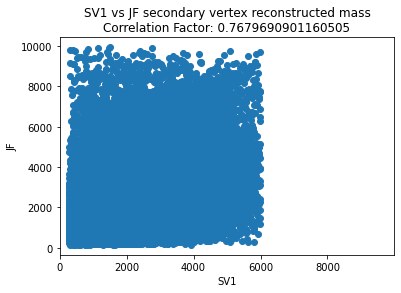

In [78]:
sv1_m = X[:,varNames=="sv1_m"]
jf_m = X[:,varNames=="jf_m"]
xlim = np.max(np.append(sv1_m,jf_m))
_ = plt.scatter(sv1_m[(sv1_m!=-1000) & (jf_m!=-1000)],jf_m[(sv1_m!=-1000) & (jf_m!=-1000)])
ax = plt.gca()
ax.set(xlim=(0,xlim))
_ = plt.xlabel("SV1")
_ = plt.ylabel("JF")
_ = plt.title("SV1 vs JF secondary vertex reconstructed mass\nCorrelation Factor: "+str(np.corrcoef(sv1_m,jf_m,rowvar=False)[0,1]))

**Osservazione:** JetFitter sembra ricostruire valori di massa più alti di SV. La correlazione c'è ma è più bassa, quindi può avere senso introdurle entrambe nel training set. Di seguito analizzo meglio le distribuzioni delle masse ricostruite per entrambi gli algoritmi.

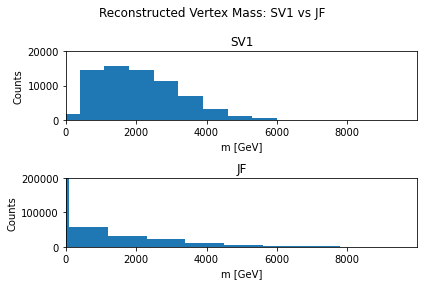

In [79]:
_ = plt.suptitle("Reconstructed Vertex Mass: SV1 vs JF")
_ = plt.subplot(211)
_ = plt.title("SV1")
_ = plt.hist(sv1_m)
_ = plt.xlabel("m [GeV]")
_ = plt.ylabel("Counts")
ax = plt.gca()
ax.set(xlim=(0,xlim),ylim=(0,2e4))

_ = plt.subplot(212)
_ = plt.title("JF")
_ = plt.hist(jf_m)
_ = plt.xlabel("m [GeV]")
_ = plt.ylabel("Counts")
ax = plt.gca()
ax.set(xlim=(0,xlim),ylim=(0,2e5))
_ = plt.tight_layout()

**Osservazione:** JetFitter spesso non ricostruisce la massa (grosso picco vicino a zero), ma quando lo fa riesce a rilevare più particelle nel vertice ricostruendo masse elevate. SV trova con più facilità i vertici ma poi perde alcuni componenti.

#### Label
Ho caricato solo le label per l-jet e b-jet. Il dataset ha una bassa percentuale di segnale. Il training set lo costruirò con 50% segnale e 50% fondo.

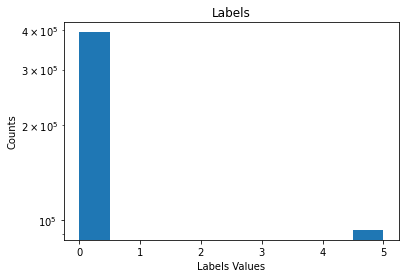

In [80]:
_ = plt.title("Labels")
_ = plt.hist(Y)
_ = plt.xlabel("Labels Values")
_ = plt.ylabel("Counts")
_ = plt.semilogy()

### Variables Selection
Vista la forte correlazione tra molte delle variabili e il peso computazionale di utilizzare tutte le variabili come features degli algoritmi, riduco la dimensionalità del dataset con due metodi (uno grezzo, l'altro più preciso ma computazionalmente più pesante).

#### Matrice di correlazione del dataset (Coefficiente di Pearson)

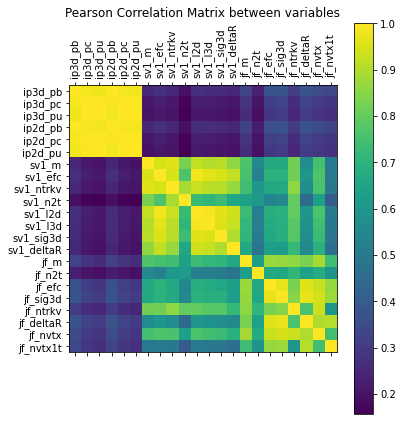

In [81]:
# calculate correlation matrix between variables
corrMatrix = np.corrcoef(X,rowvar=False)

# plot correlation matrix
num = 1
_ = plt.figure(num,figsize=(6,7))
mat = plt.matshow(corrMatrix,fignum=num)
_ = plt.colorbar(mat,location='right')
_ = plt.title("Pearson Correlation Matrix between variables")
_ = plt.xticks([i for i in range(varNames.shape[0])],varNames,rotation=90)
_ = plt.yticks([i for i in range(varNames.shape[0])],varNames)

**Osservazione:** La matrice di covarianza è approssimativamente una matrice a blocchi, indicando che le variabili di output appartenenti allo stesso low level tagger sono correlate tra di loro. Si nota bene come esista anche una correlazione (più debole) tra gli output di SV e JF: essendo entrambi tagger basati sulla ricostruzione del vertice, è ragionevole che ci sia covarianza anche tra di essi. I tagger basati sul parametro di impatto sono leggermente più correlati con JF che con SV (a mio avviso è interessante). Interessante anche la scarsa correlazione tra il parametro di impatto e il numero di tracce nel vertice secondario.

#### Rapida Selezione delle Variabili 
Algoritmo semplice. Scelgo una variabile e elimino dal dataset tutte le altre variabili correlate ad essa oltre ad una certa soglia.

In [82]:
def findUncorrelatedVariables(corrMatrix,treshold=0.9):
    dumpedVariables = []
    # loop through each row
    for i in range(corrMatrix.shape[0]):
        # loop through each column
        for j in range(i+1,corrMatrix.shape[0]):
            # if a variable is too highly correlated
            if corrMatrix[i,j] >= treshold:
                if j not in dumpedVariables:
                    dumpedVariables.append(j)

    return np.sort(np.asarray(dumpedVariables))

In [83]:
# variables selection
dumpedVariables = findUncorrelatedVariables(corrMatrix)

uncorr_X = np.delete(X,dumpedVariables,axis=1)
selectedVar_corrMatrix = np.corrcoef(uncorr_X,rowvar=False)
uncorr_varNames = np.delete(varNames,dumpedVariables,axis=0)

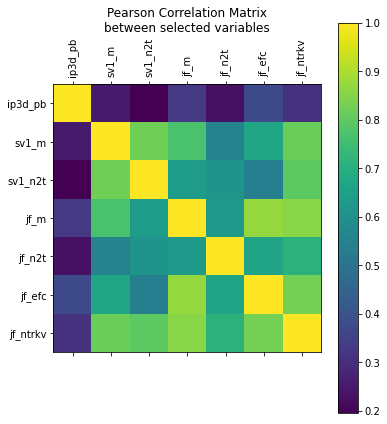

In [84]:
# plot selected variables correlation matrix
num += 1
_ = plt.figure(num,figsize=(6,7))
mat = plt.matshow(selectedVar_corrMatrix,fignum=num)
_ = plt.colorbar(mat,location='right')
_ = plt.title("Pearson Correlation Matrix\nbetween selected variables")
_ = plt.xticks([i for i in range(uncorr_varNames.shape[0])],uncorr_varNames,rotation=90)
_ = plt.yticks([i for i in range(uncorr_varNames.shape[0])],uncorr_varNames)

#### PCA Dimensionality Reduction
Algoritmo più intelligente. Raggruppo assieme le variabili correlate oltre ad una certa soglia e le proietto sulla loro componente principale. Non estraggo le prime componenti principali del dataset perchè sarebbe computazionalmente più pesante (e in più credo che perderei informazione dalle variabili scorrelate: nel mio algoritmo quest'ultime sono tenute inalterate, mentre quelle correlate vengono condensate in una sola variabile).

In [85]:
from sklearn.decomposition import PCA

In [86]:
def pcaDatasetReduction(X,corrMatrix,treshold=0.9):
    dumpedVariables = []
    aggregatedVariables = []
    reducedDataset = []
    pca = PCA(n_components=1)

    # loop through each row
    for i in range(corrMatrix.shape[0]):
        # if the variable was already reduced, ignore
        if i in dumpedVariables:
            continue
        # loop through each column
        for j in range(i+1,corrMatrix.shape[0]):
            # if a variable is too highly correlated
            if corrMatrix[i,j] >= treshold:
                if j not in dumpedVariables:
                    dumpedVariables.append(j)
                    aggregatedVariables.append(j)

        # if some correlated variables are found
        # aggregate them
        if aggregatedVariables != []:
            dumpedVariables.append(i)
            aggregatedVariables = [i] + aggregatedVariables
            # extract correlated variables
            corrVar = X[:,aggregatedVariables]
            # Find PC
            pca.fit(corrVar)
            # Project variables on PC
            projVar = pca.transform(corrVar)
            # save reduced dataset
            reducedDataset.append(projVar)
            aggregatedVariables = []
        # else, if the variable was not merged, keep the variable in the dataset
        elif i not in dumpedVariables:
            reducedDataset.append(X[:,i].T)
        else:
            pass
        
        reducedDatasetNP = reducedDataset[0]
        for array in reducedDataset[1:]:
            reducedDatasetNP = np.column_stack((reducedDatasetNP,array))

    return reducedDatasetNP

In [87]:
reducedDataset = pcaDatasetReduction(X,corrMatrix,treshold=0.85)
pca_corrMatrix = np.corrcoef(reducedDataset,rowvar=False)

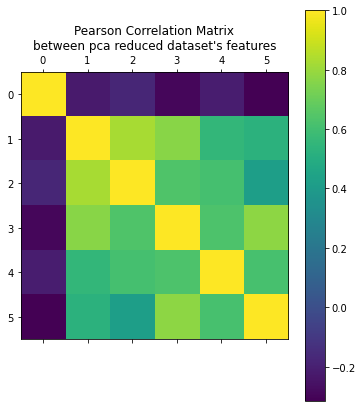

In [88]:
# plot selected variables correlation matrix
num += 1
_ = plt.figure(num,figsize=(6,7))
mat = plt.matshow(pca_corrMatrix,fignum=num)
_ = plt.colorbar(mat,location='right')
_ = plt.title("Pearson Correlation Matrix\nbetween pca reduced dataset's features")

**Osservazione:** questo dataset condensa il più possibile le informazioni del dataset globale, pur riducendo a 6 il numero di features. Il prezzo da pagare è che ora le variabili non hanno più una chiara interpretazione fisica (se si utilizzassero algoritmi di explainability tipo OMP forse il primo algoritmo di riduzione sarebbe da preferire, dato che conserva l'interpretazione fisica delle variabili).

### Supervised Learning
Per eseguire la classificazione provo diversi algoritmi tipicamente impiegati in questo contesto. Tendo a preferire (se sono sufficienti) algoritmi non basati sulle Neural Networks: a differenza delle NN, algoritmi come le SVM hanno un unico minimo nel funzionale di Loss e sono computazionalmente meno gravosi (soprattutto se non si utilizza il kernel trick). Per questo, come primo algoritmo utilizzo sempre una SVM lineare (algoritmo più semplice ma computazionalmente più efficiente), e vedo che prestazioni riesce a raggiungere (in uno spazio di input con un buon numero di features anche un separatore lineare è spesso sufficiente). Poi cerco più prestazioni di classificazione con una SVM con Kernel gaussiano, ed infine una NN.

Algoritmi provati:
- Funzionali convessi:
    - Linear SVM:
        - Costo computazionale di una predizione: O(d), con d=numero di features;
    - Kernel SVM:
        - Costo computazionale di una predizione: O(N), con N numero di punti nel training set;
- Funzionali con minimi locali:
    - NN;
    - BDT;

In [89]:
from sklearn.svm import LinearSVC as lSVM
from sklearn.svm import SVC as SVM
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import roc_auc_score as AUC
import joblib

#### Creazione Training Set e Validation Set

In [90]:
Y[(Y==5)] = 1
#Y[(Y!=1)] = -1
Y[(Y!=1)] = 0

randInd = np.array([i for i in range(Y.shape[0])])
np.random.shuffle(randInd)

#X = featureNormalization(reducedDataset[randInd,:])
X = reducedDataset[randInd,:]
Y = Y[randInd]
nTr = m.floor(X.shape[0]*0.6)

Xtr = X[:nTr,:]
Ytr = Y[:nTr]
Xval = X[nTr:,:]
Yval = Y[nTr:]

Creo un training set e un validation set più piccoli per limiti computazionali del mio PC. Conservo quelli grandi per provare ad usarli su Google Colab.

In [91]:
# Creating a smaller dataset for computational costs reasons
# Selecting on purpose 50% of signal and 50% of bkg
NtrSmall = 1000
NvalSmall = 100

Xsignal = X[Y==1]
Xbkg = X[Y==0]

XtrSmall = np.concatenate((Xsignal[:NtrSmall//2,:],Xbkg[:NtrSmall//2,:]),axis=0)
YtrSmall = np.append(np.ones(NtrSmall//2),np.zeros(NtrSmall//2))
print("Training set shape:")
print("Xtr:",XtrSmall.shape,"Ytr:",YtrSmall.shape)
XvalSmall = np.concatenate((Xsignal[NtrSmall//2:(NtrSmall//2)+(NvalSmall//2),:],Xbkg[NtrSmall//2:(NtrSmall//2)+(NvalSmall//2),:]),axis=0)
YvalSmall = np.append(np.ones(NvalSmall//2),np.zeros(NvalSmall//2))
print("Validation set shape:")
print("Xval",XvalSmall.shape,"Yval",YvalSmall.shape)

Training set shape:
Xtr: (1000, 6) Ytr: (1000,)
Validation set shape:
Xval (100, 6) Yval (100,)


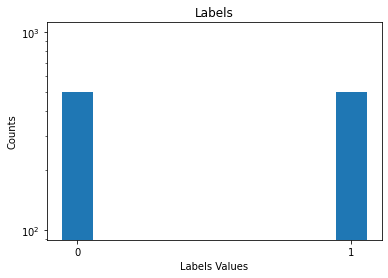

In [92]:
_ = plt.title("Labels")
_ = plt.hist(YtrSmall)
_ = plt.xticks([0.05,0.95],["0","1"])
_ = plt.xlabel("Labels Values")
_ = plt.ylabel("Counts")
_ = plt.semilogy()

**Nota:** ho equilibrato le frazioni di segnale e fondo nel training e validation set.

#### Benchmark algorithms

##### Performances MV2

In [93]:
mv2 = mv2[randInd]
fpr_mv2,tpr_mv2,_ = ROC(np.append(Ytr,Yval),mv2)
auc_mv2 = AUC(np.append(Ytr,Yval),mv2)

##### Performances BDT with 4-dim feature space
Per provare la suite TMVA ho utilizzato le macro allenando un BDT con 4 features; ho aggiunto, alle tre già inserite, la massa del vertice secondario ricostruita da JetFitter.

In [94]:
decisionBDT = []
with open("decisionBDT.dat","r") as ifile:
    for line in ifile:
        decisionBDT.append(float(line))

decisionBDT = np.asarray(decisionBDT)[randInd]
fpr_BDT,tpr_BDT,_ = ROC(np.append(Ytr,Yval),decisionBDT)
auc_BDT = AUC(np.append(Ytr,Yval),decisionBDT)

#### ROC plot function
La ROC calcolata da `sklearn` utilizza i rate di veri positivi (tpr) e falsi positivi (fpr), quindi non rispecchia le ROC tipiche di ATLAS che plottano l'efficienza di reiezione del fondo sull'asse y. Per preservarne almeno la forma ho graficato la quantità (1-fpr) sull'asse delle y.

In [108]:
def makeROC(decisions,Yval,algoNames=[""],filename="",log=True):
    global tpr_mv2,fpr_mv2,tpr_BDT,fpr_BDT
    fig,(a0,a1) = plt.subplots(2,1,gridspec_kw={'height_ratios': [4, 1]},figsize=(7,6))
    _ = a0.plot(tpr_mv2,(1-fpr_mv2),label='mv2 AUC='+str(round(auc_mv2,3)),color='red')
    _ = a0.plot(tpr_BDT,(1-fpr_BDT),label='BDT 4 features AUC='+str(round(auc_BDT,3)),color='black')
    _ = a0.set_title("ROCs comparison")
    for decision,algoName in zip(decisions,algoNames):
        fpr,tpr,_ = ROC(Yval,decision)
        auc = AUC(Yval,decision)
        _ = a0.plot(tpr,1-fpr,label=algoName + " AUC=" + str(round(auc,3)))
        _ = a0.set_xlabel("True Positive Rate")
        _ = a0.set_ylabel("1-False Positive Rate")

        fpr_mv2_ratio = []
        for t in tpr:
            index = np.argmin(tpr_mv2-t)
            fpr_mv2_ratio.append((1-fpr_mv2[index])**-1)
        fpr_mv2_ratio = np.asarray(fpr_mv2_ratio)
        _ = a1.plot(tpr,(1-fpr)*fpr_mv2_ratio,label=algoName+"/mv2")
        _ = a1.set_xlabel("True Positive Rate")
        _ = a1.set_ylabel("1-fpr\nRatio")

    ticks = np.linspace(0,1,11)
    a0.set_xticks(ticks)
    a0.set_yticks(ticks)
    if log:
        _ = a0.semilogy()
    _ = a0.grid()
    _ = a0.legend(loc='best')
    a1.set_xticks(ticks)
    a1.set_yticks(ticks)
    _ = a1.plot(np.linspace(0,1,11),[1]*11,'r--',alpha=0.5,label="1")
    _ = a1.semilogy()
    _ = a1.grid()
    _ = a1.legend(loc='best')
    plt.tight_layout()
    if filename!="":
        plt.savefig(filename,dpi=200)

#### Linear SVM
L'implementazione della SVM lineare di `sklearn` non è proprio aderente alla definizione che si trova in letteratura. Per prima cosa, aggiunge una feature "fittizzia" per stimare un eventuale offset dell'iperpiano (rendendolo di fatto un separatore non lineare). Ma soprattutto è necessario specificare esplicitamente di usare la loss function Hinge perchè non è la scelta di default.

In [96]:
lsvm = lSVM(verbose=1,loss='hinge',max_iter = 5000)

try:
    lsvm = joblib.load("savedModels/lsvmModel.pkl")
except:
    lsvm.fit(XtrSmall, YtrSmall)
    joblib.dump(lsvm,"savedModels/lsvmModel.pkl")

In [97]:
lsvm.score(Xval,Yval)

0.8519031781226903

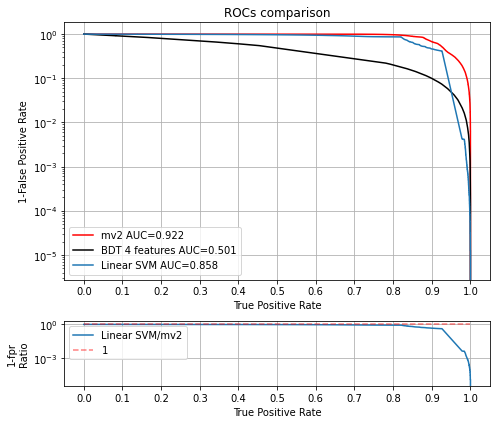

In [98]:
decisionLsvm = lsvm.decision_function(Xval)
makeROC([decisionLsvm],Yval,["Linear SVM"])

#### Kernel SVM
**Cross-Validation:** per la SVM con il kernel trick eseguo un semplice processo di Cross-Validation per portare l'algoritmo ad un buon punto di efficienza. Con la CV trovo i "migliori" valori per il parametro di regolarizzazione e per il parametro del kernel.

Nota per me stesso:
Utilizzo un kernel gaussiano, definito da `sklearn` come: 
$$K(x_i,x_j) = e^{-\gamma||x_i-x_j||^2}$$
Normalmente, in letteratura, il Kernel gaussiano è definito come:
$$K(x_i,x_j) = e^{-\frac{||x_i-x_j||^2}{\sigma^2}}$$
Segue che il ruolo del parametro del Kernel di `sklearn` ($\gamma$ per `sklearn`, $\sigma$ in letteratura) è l'inverso del normale: grandi $\gamma$ danno poca larghezza di banda al singolo punto del training set.

**Regolarizzazione**: nuovamente le scelte di `sklearn` sono atipiche rispetto alla letteratura. La penalizzazione in norma è eseguita con il parametro $C$ che è l'inverso del tipico parametro di regolarizzazione $\lambda$.
La loss è definita come: 
$$\hat{L} = C \frac{1}{N}\sum_i l(y_i,f(x_i) + ||f||_{\mathcal{H}}^2$$
Normalmente il parametro di regolarizzazione è introdotto come moltiplicatore di Lagrange sulla penalizzazione: 
$$\hat{L} = \frac{1}{N}\sum_i l(y_i,f(x_i) + \lambda||f||_{\mathcal{H}}^2$$
Segue che la regolarizzazione, in questo caso, è tanto più grande quanto più piccolo è $C$.

In [99]:
svm = SVM()
try:
    svm = joblib.load("savedModels/svmModel.pkl")
except:
    # cross-validation on hyperparam c (1/lamb) and gamma (1/sigma)
    scores = np.zeros(shape=(10,10))
    cs = np.logspace(-6,1,10)**-1
    gs = np.logspace(-6,1,10)**-1
    for i,j in zip([l for l in range(10)],[m for m in range(10)]):
        c,g = cs[i],gs[j]
        svm = SVM(kernel='rbf',C = c,gamma=g)
        svm.fit(XtrSmall,YtrSmall)
        scores[i,j] = svm.score(XvalSmall,YvalSmall)
    scores = np.asarray(scores)
    print("Indexes of best lamb and sigma:")
    print(np.unravel_index(np.argmax(scores),scores.shape))
    bestC = cs[np.unravel_index(np.argmax(scores),scores.shape)[0]]
    bestG = gs[np.unravel_index(np.argmax(scores),scores.shape)[1]]
    svm = SVM(kernel='rbf',C = bestC, gamma=bestG)
    svm.fit(XtrSmall,YtrSmall)
    joblib.dump(svm,"savedModels/svmModel.pkl")
    # plot CV results
    mat = plt.matshow(scores)
    _ = plt.title("Cross Validation on $\lambda$ and $\sigma$ with Kernel SVM\nBest $\lambda$="+str(bestC**-1)+"\nBest $\sigma$="+str(bestG**-1))
    _ = plt.xlabel("#$\lambda$")
    _ = plt.ylabel("#$\sigma$")
    _ = plt.colorbar()

In [100]:
svm.score(Xval,Yval)

0.849069967972407

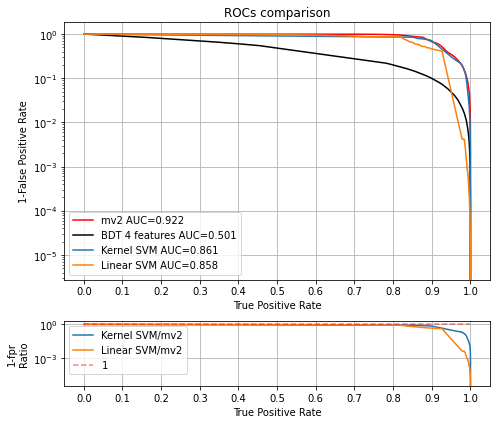

In [101]:
decisionKsvm = svm.decision_function(Xval)
makeROC([decisionKsvm,decisionLsvm],Yval,["Kernel SVM", "Linear SVM"])

#### Neural Network
Provo una semplice Neural Network, senza alcun processo di model selection (per ragioni di costo computazionale). Genero una NN che abbia una complessità accettabile e seleziono il numero di epochs in modo da evitare un pesante overfitting.

In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [103]:
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model loss')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

In [104]:
try:
    model = keras.models.load_model('savedModels/NN')
except:
    # Initializing the model
    model = Sequential()
    model.add(Dense(32,input_dim = XtrSmall.shape[1], activation='relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(1,activation = 'sigmoid'))

    model.compile(
        optimizer = 'adam',
        loss='binary_crossentropy',
        metrics =['accuracy']
    )
    
    # Training
    history = model.fit(XtrSmall,YtrSmall,
        epochs = 50,
        batch_size = 10,
        validation_data = (XvalSmall,YvalSmall))
    model.save("savedModels/NN")
    fig, ax = plot_history(history)


In [105]:
decisionNN = model.predict(Xval)

#### ROC complessive di tutti gli algoritmi provati
Note:
- Purtroppo i valori di tpr delle varie curve non sono gli stessi, quindi il rapporto dei fpr rispetto a mv2 è leggermente sballato perchè non è calcolato alla stessa precisa efficienza di segnale;

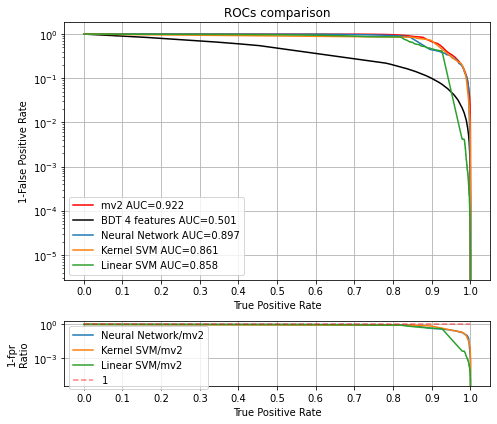

In [106]:
makeROC([decisionNN,decisionKsvm,decisionLsvm],Yval,["Neural Network","Kernel SVM", "Linear SVM"],filename="ROCsComparision.jpg")

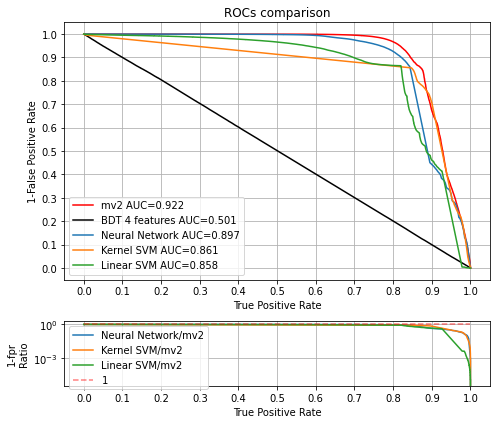

In [109]:
makeROC([decisionNN,decisionKsvm,decisionLsvm],Yval,["Neural Network","Kernel SVM", "Linear SVM"],log=False,filename="ROCsComparisionNoLog.jpg")

**Osservazioni:**
- Seppur allenati su molti meno dati (ma con 2 feature in più), gli algoritmi lSVM,SVM e NN superano BDT;
- kSVM non offre grandi purezze a basse efficienze di segnale (curioso, fenomeno probabilmente dovuto ad un po' di overfitting) ma offre purezze comparabili ad mv2 ad alte efficienze di segnale;
- lSVM offre grande purezza e grande stabilità a basse efficienze di segnale, poi degrada (discorso opposto a kSVM: essendo un modello più semplice ha poco overfitting ma poi va in underfitting);
- La NN lavora bene ad altissime efficienze di segnale: lì la funzione target deve essere molto complicata, dato che kSVM e NN riescono ad approssimarla (mentre lSVM no).

### Unsupervised Learning

#### First two PCs
Provo a graficare le prime due componenti principali del training set globale (basandomi solo sui primi 10000 punti per motivi computazionali), per osservare se i dati siano separabili in 2D.

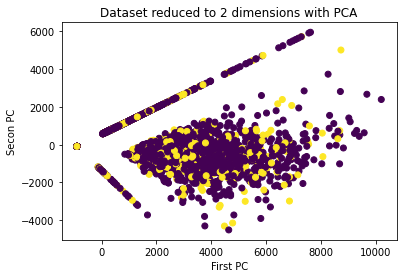

In [107]:
pca = PCA(n_components=2)
pca.fit(np_df[:10000])
viewableData = pca.transform(np_df[:10000])
_ = plt.scatter(viewableData[:10000,0],viewableData[:10000,1],c=Y[:10000])
_ = plt.title("Dataset reduced to 2 dimensions with PCA")
_ = plt.xlabel("First PC")
_ = plt.ylabel("Secon PC")

**Osservazione:** i dati sono evidentemente non separabili; quelli disposti su due rette credo siano dovuti all'attribuzione arbitraria di valori non fisici quado la variabile non può essere ricostruita.

### Migliorie/altre idee ancora da implementare

- Normalizzare e centrare le features (molte sono già normalizzate ma alcune no, e gli algoritmi basati sulle distanze come SVM hanno un bias sul valore assoluto delle feature);
- Per risurre lo stesso bias del punto precedente si possono applicare trasformate che riducano la skeweness delle features (eg trasformata di Yeo-Johnson);
- fine tuning dei modelli (eg CV sulla profondità della NN);